## Import necessary python libraries

In [23]:
import feyn
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
import warnings
warnings.filterwarnings('ignore')
feyn._qlattice._USE_V2_API = True
from custom_function import *
import collections
import gseapy as gp
import os
# simple plotting function
from gseapy.plot import barplot, dotplot
from Bio import Entrez

In [24]:
import dirac.crossval
from dirac.crossval import *

In [25]:
class ModelResults:
    def __init__(self, kind="classification"):
        self.kind = kind

        if self.kind == "classification":
            self.df = pd.DataFrame(columns=['model_structure', 'fold', 'aic', 'bic', 'roc_auc', 'accuracy', 'pr_auc',
                                            'f1'])
        elif self.kind == "regression":
            self.df = pd.DataFrame(columns=['model_structure', 'fold', 'aic', 'bic', 'rmse', 'mae', 'r2_score'])
        else:
            raise ValueError("kind must be classification or regression")

    def update(self, train, val, fold, model):
        if model:
            if self.kind == "classification":
                model_precision, model_recall, _ = precision_recall_curve(val[model.output], model.predict(val))
                if model:
                    self.df = self.df.append(pd.DataFrame(data={
                        'model_structure': [str(model.sympify(include_weights=False))],
                        'fold': [fold],
                        'aic': [model.aic],
                        'bic': [model.bic],
                        'roc_auc': [model.roc_auc_score(val)],
                        'accuracy': [model.accuracy_score(val)],
                        'pr_auc': [auc(model_recall, model_precision)],
                        'f1': [f1_score(val[model.output], model.predict(val) > model.accuracy_threshold(train)[0])]
                    }))

            elif self.kind == "regression":
                if model:
                    preds = model.predict(val)
                    self.df = self.df.append(pd.DataFrame(data={
                        'model_structure': [str(model.sympify(include_weights=False))],
                        'fold': [fold],
                        'aic': [model.aic],
                        'bic': [model.bic],
                        'rmse': [feyn.metrics.rmse(val[model.output], preds)],
                        'mae': [feyn.metrics.mae(val[model.output], preds)],
                        'r2_score': [feyn.metrics.r2_score(val[model.output], preds)]
                    }))




In [26]:
feyn.__version__

'2.1.1'

## Load necessary files

In [27]:
expression_table = 'insulin_dataset.csv'
data_togo = pd.read_csv(expression_table, sep=',')


In [28]:
data_togo.head()

,Cond,7SK,A1BG,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZYX,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-3180-3,hsa-mir-3180-4,hsa-mir-6080,hsa-mir-8072,Class_,CV_Split
0,NG1f0,61.707,0.869,22.325312,5.504,1.3035,26.7975,6.373,77.641,1.3035,...,14.70225,27.232,11.0085,1.5930,1.4490,0.869,1.738,2.028,0.0,0.0
1,NG1h0,67.008,1.600,29.549125,4.621,2.7550,22.2175,43.013,57.232,3.7325,...,17.32925,29.149,13.0635,2.0440,2.0440,0.711,0.889,2.488,1.0,0.0
2,NG2f0,37.882,3.164,20.439625,7.035,23.3330,28.9115,19.316,51.453,1.7900,...,41.75375,57.489,10.6155,6.6395,11.3650,7.576,1.499,1.957,0.0,1.0
3,NG2h0,75.477,2.901,16.411500,6.017,24.4965,30.2445,20.091,62.101,1.4775,...,25.87975,58.394,11.2005,5.6140,8.5955,4.029,1.558,1.826,1.0,1.0
4,NG3f0,131.061,8.107,13.412812,16.214,43.6870,28.3740,3.828,0.000,1.0135,...,60.01325,47.515,4.5040,6.3055,3.7155,1.126,0.901,3.828,0.0,2.0


In [29]:
# make dictionary to store original features names
features_dict = dict()
for genes_names in data_togo.columns:
    qlattice_gene_names = genes_names.replace(".", "_").replace(".", "_")
    features_dict[qlattice_gene_names] = genes_names

## Standardise feature names

In [31]:
data_togo.columns = data_togo.columns.str.replace(".", "_")
data_togo.columns = data_togo.columns.str.replace("-", "_")

In [32]:
data_togo

,Cond,7SK,A1BG,A2M,A2M_AS1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZYX,ZZEF1,ZZZ3,hsa_mir_1199,hsa_mir_3180_3,hsa_mir_3180_4,hsa_mir_6080,hsa_mir_8072,Class_,CV_Split
0,NG1f0,61.707,0.869,22.325312,5.504,1.3035,26.7975,6.373,77.641,1.3035,...,14.70225,27.232,11.0085,1.5930,1.4490,0.869,1.738,2.028,0.0,0.0
1,NG1h0,67.008,1.600,29.549125,4.621,2.7550,22.2175,43.013,57.232,3.7325,...,17.32925,29.149,13.0635,2.0440,2.0440,0.711,0.889,2.488,1.0,0.0
2,NG2f0,37.882,3.164,20.439625,7.035,23.3330,28.9115,19.316,51.453,1.7900,...,41.75375,57.489,10.6155,6.6395,11.3650,7.576,1.499,1.957,0.0,1.0
3,NG2h0,75.477,2.901,16.411500,6.017,24.4965,30.2445,20.091,62.101,1.4775,...,25.87975,58.394,11.2005,5.6140,8.5955,4.029,1.558,1.826,1.0,1.0
4,NG3f0,131.061,8.107,13.412812,16.214,43.6870,28.3740,3.828,0.000,1.0135,...,60.01325,47.515,4.5040,6.3055,3.7155,1.126,0.901,3.828,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,NO77h2,81.744,3.071,19.550250,11.340,3.6620,25.5155,26.933,106.787,2.2445,...,19.13675,35.674,12.2855,2.5990,1.7720,0.236,0.473,1.890,1.0,4.0
134,NO89f0,75.857,2.423,8.565000,6.664,47.7895,28.3035,4.981,6.664,0.9090,...,43.80125,65.761,4.6440,7.2695,3.5675,1.750,1.010,4.981,0.0,0.0
135,NO89f2,308.708,2.424,21.948313,2.277,6.9425,33.7580,5.877,74.349,2.0940,...,26.08100,25.934,10.1385,3.1590,1.4695,1.102,0.882,1.837,0.0,0.0
136,NO89h0,151.748,2.106,6.307750,7.538,56.1985,26.9635,22.668,7.039,1.8845,...,37.36900,62.462,4.3785,5.9580,4.8770,2.605,1.275,6.595,1.0,0.0


## Training a QLattice in a cross-validation scheme as framework


In [18]:
logdir='../models_insulin_paper/'
os.makedirs(logdir, exist_ok=True)


partitions_interval = np.arange(5)
inner_partitions_interval = partitions_interval#[partitions_interval != 4]

results = ModelResults()


for val_partition in inner_partitions_interval:
    os.makedirs('%spartition_%i' % (logdir, val_partition), exist_ok=True)
    model_file = "%spartition_%i/model" % (logdir, val_partition)
    train = data_togo.loc[(data_togo.CV_Split != val_partition)]
    val = data_togo.loc[(data_togo.CV_Split == val_partition)]
    
    # Connecting to the QLattice
    
    ql = feyn.connect_qlattice()

    # Setting a seed
    
    ql.reset(random_seed=42)  

    stypes = dict()
    for f in train.columns:
        if train[f].dtype =='object':
            stypes[f] = 'c'
            
    models_ = ql.auto_run(data=train,
                          output_name="Class_",
                          kind="classification",
                          n_epochs=50,
                          max_complexity=5,
                          stypes=stypes,
                          criterion="bic",
                 )
    
    for j in models_:
        results.update(train, val, val_partition, j)
    
    for i in range(len(models_)):    
        models_[i].save(model_file+'_'+str(val_partition)+'_'+str(i)+'.json')

In [19]:
results.df

,model_structure,fold,aic,bic,roc_auc,accuracy,pr_auc,f1
0,logreg(CBX4 + GPR132 + HIST1H1D),0,40.565948,45.930211,0.897778,0.866667,0.911572,0.827586
0,logreg(ASL + CBX4),0,47.444801,50.126933,0.924444,0.833333,0.927758,0.800000
0,logreg(AC0169123 + C19orf80 + SRFBP1),0,45.435287,50.799550,0.946667,0.900000,0.959950,0.896552
0,logreg(exp(ARHGAP8 + HMGCS1)),0,45.802027,51.166290,0.915556,0.900000,0.938762,0.888889
0,logreg(HMGCS1 + PHF23 + RNU3P3),0,46.273112,51.637375,0.977778,0.900000,0.979951,0.928571
0,logreg(CDKN1A + GYS1 + SH3BGRL2),0,46.704138,52.068400,0.964444,0.933333,0.953725,0.933333
0,logreg(FMNL3 + LDHD + PPP1R3B),0,47.454822,52.819085,0.964444,0.866667,0.970762,0.838710
0,logreg(1/(DUSP4 + HMGCS1)),0,48.826477,54.190740,0.960000,0.866667,0.954463,0.720000
0,logreg(PHF23 + RNU118P),0,52.547590,55.229722,0.933333,0.866667,0.956244,0.903226
0,logreg(tanh(SPRY4)),0,53.143528,55.825659,0.924444,0.933333,0.952351,0.933333


In [20]:
results.df[:10].bic.mean()
results.df[:10].bic.min()
results.df[:10].bic.max()

55.82565899315823

## Training a QLattice in train-test split mode for final model choice



In [21]:
#for i in range(len(models_)):
#    models_[i].show()


In [22]:
logdir='../models_insulin_paper_train_test/'
os.makedirs(logdir, exist_ok=True)

results_train_test = ModelResults()
os.makedirs('%spartition_%i' % (logdir, 1), exist_ok=True)
model_file = "%spartition_%i/model" % (logdir, 1)
train = data_togo.loc[(data_togo.CV_Split != 4)]
test = data_togo.loc[(data_togo.CV_Split == 4)]

# Connecting to the QLattice

ql = feyn.connect_qlattice()

# Setting a seed

ql.reset(random_seed=42)  

stypes = dict()
for f in train.columns:
    if train[f].dtype =='object':
        stypes[f] = 'c'

models_ = ql.auto_run(data=train,
                      output_name="Class_",
                      kind="classification",
                      n_epochs=50,
                      max_complexity=5,
                      stypes=stypes,
                      criterion="bic",
             )

for j in models_:
    results_train_test.update(train, test, 1, j)

for i in range(len(models_)):    
    models_[i].save(model_file+'_'+str(1)+'_'+str(i)+'.json')

In [23]:
results_train_test.df

,model_structure,fold,aic,bic,roc_auc,accuracy,pr_auc,f1
0,logreg(C10orf10 + GLI2 + LDLR),1,50.171777,55.572738,1.000000,1.000000,1.000000,1.000000
0,logreg(exp(PDK4 + TEX10**2)),1,48.787630,56.889071,0.969388,0.892857,0.973796,0.848485
0,logreg(tanh(AC1008023 + RAB3A)),1,52.624298,58.025259,0.969388,0.928571,0.975383,0.928571
0,logreg(C10orf10 + KLC2 + MIR4453),1,55.049655,60.450616,0.989796,0.928571,0.989770,0.965517
0,logreg(SPRY4*UBASH3B),1,55.290786,60.691747,0.989796,0.964286,0.989770,0.888889
0,logreg(HEXIM1 + log(BHLHE40)),1,55.451569,60.852530,1.000000,1.000000,1.000000,0.880000
0,logreg(ZNF136 + tanh(SPRY4)),1,57.447171,62.848131,1.000000,0.928571,1.000000,0.923077
0,logreg(CATG000000724171 + CSRNP2*MSX1),1,56.047268,64.148709,1.000000,0.928571,1.000000,0.965517
0,logreg(EXT1 + tanh(SPRY4)),1,58.942808,64.343769,1.000000,1.000000,1.000000,0.923077
0,logreg(1/(C19orf80 + SOAT1)),1,59.129290,64.530251,0.979592,0.892857,0.979752,0.933333


In [96]:
#models_[0].plot_response_2d(test)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 731 232.0" width="731" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>Class_
logistic:
w=-4.0257
bias=0.6778</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">Class_</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>C10orf10
linear:
scale=0.005003
scale offset=107.293964
w=2.388871
bias=0.0342</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">C10orf10</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>GLI2
linear:
scale=0.452284
scale offset=1.464355
w=-0.459722
bias=-0.2293</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">GLI2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>LDLR
linear:
scale=0.058195
scale offset=8.569500
w=-1.995404
bias=0.3227</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">LDLR</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="471" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14
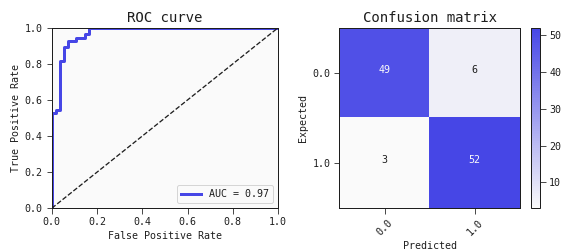
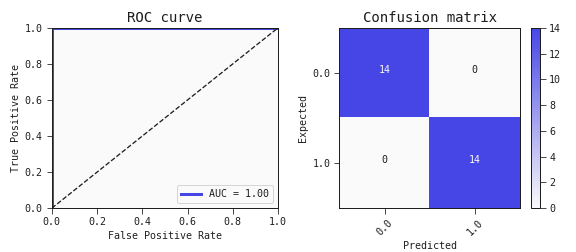

In [95]:
models_[0].plot(train,test)

In [26]:
feat_list = list()
for i in range(len(models_)):
    genes = models_[i].features
    for gene in genes:
        feat_list.append(gene)

In [27]:
count_features = collections.Counter(feat_list)
count_features_df = pd.DataFrame(count_features.items(),columns=['Gene', 'Count']).sort_values('Count', ascending=False)

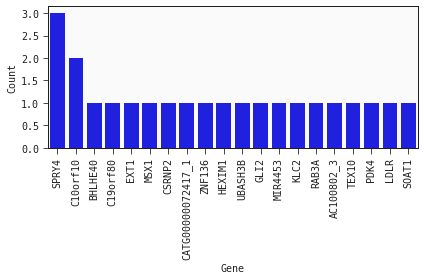

In [28]:
sns.barplot(x=count_features_df.Gene,y=count_features_df.Count, color='blue')
plt.xticks(rotation=90)
plt.tight_layout()

In [29]:
#models_[0].plot_response_1d(test, 'C10orf10')

In [30]:
#gene_list = feat_list
gene_list = models_[0].features

In [31]:
gene_original = list()
for i in gene_list:
    if i in features_dict.keys():
        gene_original.append(features_dict[i])

In [32]:
# This links provides the potential database to use https://maayanlab.cloud/Enrichr/#libraries
# Those are the one I used the most
# 'GWAS_Catalog_2019', 'HMDB_Metabolites','Human_Phenotype_Ontology',
# 'Jensen_DISEASES', 'Jensen_TISSUES', 
# 'KEGG_2021_Human','MGI_Mammalian_Phenotype_Level_4_2021',
# 'Disease_Signatures_from_GEO_down_2014', 
# 'Disease_Signatures_from_GEO_up_2014'
# 'GO_Biological_Process_2021','huMAP'
                 
def gsea(dataset, gene_list):
    enr = gp.enrichr(gene_list=gene_list,#models_[4].features,
                 gene_sets=[dataset],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 #outdir='test/enrichr_kegg',
                 background='hsapiens_gene_ensembl', #list(data_togo.columns), #
                 #no_plot=False,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )
    return enr

In [33]:
enrichment = gsea('KEGG_2021_Human', gene_original)

In [34]:
enrichment.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cholesterol metabolism,1/50,0.007482,0.027212,0,0,203.551020,996.446358,LDLR
1,KEGG_2021_Human,Ovarian steroidogenesis,1/51,0.007631,0.027212,0,0,199.470000,972.528412,LDLR
2,KEGG_2021_Human,Hedgehog signaling pathway,1/56,0.008377,0.027212,0,0,181.290909,866.984986,GLI2
3,KEGG_2021_Human,Basal cell carcinoma,1/63,0.009421,0.027212,0,0,160.766129,749.950338,GLI2
4,KEGG_2021_Human,Cortisol synthesis and secretion,1/65,0.009719,0.027212,0,0,155.726562,721.590219,LDLR
5,KEGG_2021_Human,Bile secretion,1/90,0.013440,0.029237,0,0,111.842697,481.989258,LDLR
6,KEGG_2021_Human,Aldosterone synthesis and secretion,1/98,0.014629,0.029237,0,0,102.577320,433.365657,LDLR
7,KEGG_2021_Human,Toxoplasmosis,1/112,0.016707,0.029237,0,0,89.576577,366.541985,LDLR
8,KEGG_2021_Human,Cushing syndrome,1/155,0.023071,0.030867,0,0,64.425325,242.829844,LDLR
9,KEGG_2021_Human,Hepatitis C,1/157,0.023367,0.030867,0,0,63.592949,238.883548,LDLR


<AxesSubplot:title={'center':'GSEA'}, xlabel='-log$_{10}$(P-value)'>

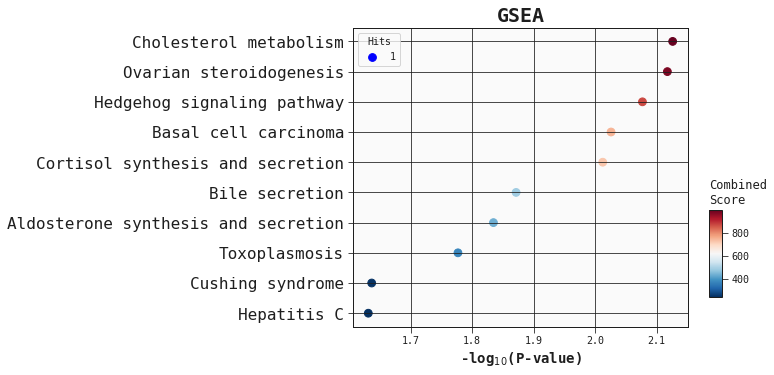

In [35]:
# to save your figure, make sure that ``ofname`` is not None
dotplot(enrichment.results, column='P-value',title='GSEA', cutoff=0.05)

In [36]:
def correlated_features(model, data):
    best_model= models_[model]
    data_wo_target = data.drop('Class_', axis = 1)
    data_wo_target = data_wo_target.drop('CV_Split', axis = 1)
    data_wo_target = data_wo_target.drop('Cond', axis = 1)
    df = data_wo_target
    feat_m = best_model.features
    # Take a subset of features with absolute correlation of 0.85 to the feature of the best model
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    corr_feat = corr_matrix.loc[feat_m]
    to_keep = [column for column in corr_feat.columns if any(corr_feat[column] > 0.75)]# and any(upper[column] < -0.95)]
    sample_data = data[to_keep]
    features_model = corr_matrix[feat_m]
    
    
    return to_keep
    #plt.tight_layout()

In [37]:
high_correlated_features = correlated_features(0, test)

In [38]:
geneL = list()
for i in high_correlated_features:
    if i in features_dict.keys():
        geneL.append(features_dict[i])

In [39]:
enrichment_correlated = gsea('GWAS_Catalog_2019', geneL)

<AxesSubplot:title={'center':'GSEA'}, xlabel='-log$_{10}$(P-value)'>

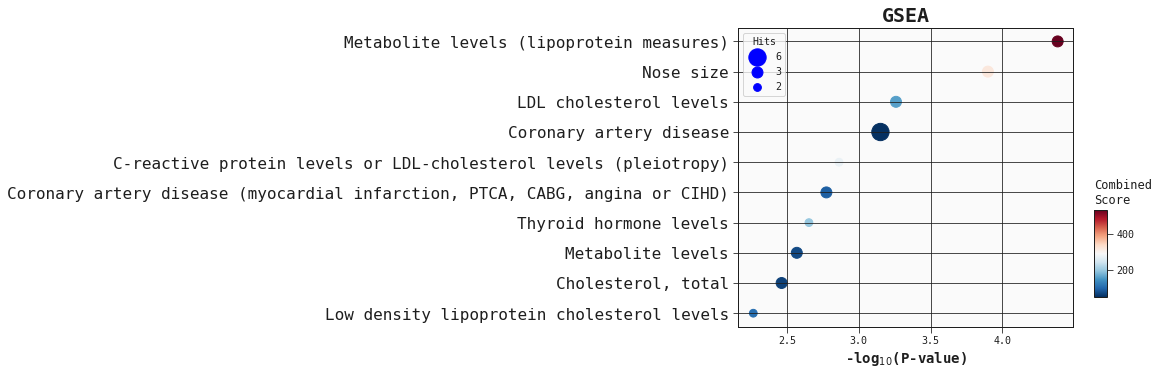

In [40]:
# simple plotting function
from gseapy.plot import barplot, dotplot

# to save your figure, make sure that ``ofname`` is not None
dotplot(enrichment_correlated.results, column='P-value',title='GSEA', cutoff=0.05)

In [91]:
if __name__ == '__main__':
    results = search('GLI2', 1)# AND insulin resistance AND Human')
    id_list = results['IdList']
    #print(id_list)
    papers = fetch_details(id_list)
    for i, paper in enumerate(papers['PubmedArticle']):
        #print(id_list[i])
        #print(paper['MedlineCitation']['Article']['ArticleTitle'])
        print(paper['MedlineCitation']['Article']['Abstract'])
        
        #print("{}) {} {} {} ".format(i+1, id_list[i], paper['MedlineCitation']['Article']['ArticleTitle'],paper['MedlineCitation']['Article']['Abstract']))

{'AbstractText': [StringElement('Gastric cancer (GC) is the fifth most commonly diagnosed cancer worldwide. Due to the dismal prognosis, identifying novel therapeutic targets in GC is urgently needed. Evidences have shown that miRNAs played critical roles in the regulation of tumor initiation and progression. GLI family zinc finger 2 (GLI2) has been reported to be up-regulated and facilitate cancer progression in multiple malignancies. In this study, we focused on identifying GLI2-targeted miRNAs and clarifying the underlying mechanism in GC.', attributes={'Label': 'BACKGROUND'}), StringElement('Paired fresh gastric cancer tissues were collected from gastrectomy patients. GLI2 and miRNAs expression were detected in gastric cancer tissues and cell lines. Bioinformatics analysis was used to predict GLI2-targeted miRNAs and dual-luciferase reporter assay was applied for target verification. CCK-8, clone formation, transwell and flow cytometry were carried out to determine the proliferatio